In [1]:
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.autograd import Variable
import os
import numpy as np
import sklearn.datasets
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
!pip install POT
!pip install python-tsp
from python_tsp.exact import solve_tsp_dynamic_programming
import ot

Looking in indexes: https://build-nexus.prod.crto.in/repository/pypi/simple
You should consider upgrading via the '/mnt/nfs/home/u.tanielian/few_shot_learning_gans/venv/bin/python3 -m pip install --upgrade pip' command.
Looking in indexes: https://build-nexus.prod.crto.in/repository/pypi/simple
You should consider upgrading via the '/mnt/nfs/home/u.tanielian/few_shot_learning_gans/venv/bin/python3 -m pip install --upgrade pip' command.


In [3]:
Lip_generator_c = 100 # > 0 if we want a lipschitz constraint on the generator, 0 otherwise
opt_penalty_weight = 1000.0 # penalty weight term lambda
opt_dataset = 'six' # fork,fork2,fork11,groups
opt_niter = 100000
opt_lrD = 0.00005 # learning rate for Critic
opt_lrG = 0.00005 # learning rate for Generator
opt_cuda = False
opt_clamp_lower = -0.01
opt_clamp_upper =  0.01
opt_Diters = 10 # number of D iters per each G iter
opt_adam = True  # Whether to use adam (default False is rmsprop)
opt_prefix = None # whether to write images (=prefix of type string) or show in notebook (=None)

opt_manualSeed = 15042017
print("Random Seed: ", opt_manualSeed)
random.seed(opt_manualSeed)
np.random.seed(opt_manualSeed)
torch.manual_seed(opt_manualSeed)
cudnn.benchmark = True

Random Seed:  15042017


In [26]:
def inf_train_gen(DATASET='fork'):
    if DATASET == 'fork':
        centers = [[0,0],[0,1],[0,2],[0,3],[-1.5,4],[1.5,4]]
    if DATASET == 'forkBase':
        centers = [[0,0],[0,1.5], [0,3],[-1.5,4],[1.5, 3.5]]
    if DATASET == 'fork2':
        centers = [[0,0],[0,1],[0,2],[0,3],[-0.5,10/3],[-1,11/3],[-1.5,4],[0.5,10/3],[1,11/3],[1.5,4]]
    elif DATASET == 'four':
        centers = [[-1, 0], [0, 0], [1, 1], [1, -1]]
    elif DATASET == 'five':
        centers = [[-1, 1], [-1, -1], [1, -1], [1, 1], [0,0]]
    if DATASET == 'six':
        centers = [[-1, 1], [1, 1], [2, 0], [1, -1], [-1, -1], [-2, 0]] 
    elif DATASET == 'seven':
        centers = [[-1, 1], [-0.7, 1], [-1, -1], [1, -1], [0.7, 1], [1, 1], [0,-1]]
    elif DATASET == 'nine':
        centers = [[-1, 1],[0, 1],[1, 1],[-1, 0],[0, 0],[1, 0], [-1, -1], [0, -1], [1, -1]]
    elif DATASET == 'sixteen':
        centers = [[-1, -2], [-1, -1], [-1, 0], [-1, 1], \
                                [0, -2], [0, -1], [0, 0], [0, 1], \
                                [1, -2], [1, -1], [1, 0], [1, 1], \
                                [2, -2], [2, -1], [2, 0], [2, 1]]
    elif DATASET == 'ten':
        np.random.seed(0)
        centers = [(np.random.rand(2) - 0.5)*3 for i in range(10)]
    if DATASET == 'fork11':  
        centers = [[-1,0],[-0.5,1],[-1,2], [0,0.8],[0,1],[0,1.2],[1,0],[0.5,1],[1,2], [1.5,0.95],[1.5,1.05]]
    if DATASET == 'groups':
        centers = [[-1.05,-0.05],[-1,0],[-1.1,0],[-1.05,0.05],[0.05,0.5],[-0.05,0.5],[0,0.55],[0,0.45],[1,0],[1.1,0],[1.05,0.05],[1.05,-0.05]]
    dataset = np.array(centers, dtype='float32')
    return dataset


In [27]:
class MyLeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.01):
        super(MyLeakyReLU, self).__init__()
        self.negative_slope = negative_slope
    def forward(self, x):
        return torch.clamp(x, min=0.0)+torch.clamp(x, max=0.0)*self.negative_slope

class ToyGAN_G(nn.Module):
    def __init__(self, dim_hidden=100, dim_out=2, noise_dim=1):
        super(ToyGAN_G, self).__init__()
        self.dim_hidden, self.dim_out, self.noise_dim = dim_hidden, dim_out, noise_dim
        self.net = nn.Sequential(
            nn.Linear(noise_dim, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_out)
            )
    def forward(self, x):
        x = self.net(x)
        return x

class ToyGAN_D(nn.Module):
    def __init__(self, dim_hidden=100, dim_gen_out=2):
        super(ToyGAN_D, self).__init__()
        self.dim_hidden, self.dim_gen_out = dim_hidden, dim_gen_out
        self.net = nn.Sequential(
            nn.Linear(dim_gen_out, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, 1)
            )
    def forward(self, x): #?
        x = self.net(x)
        return x.view(-1)


def cost_Matrix(x,y):
    M = np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            M[i,j] = np.linalg.norm(x[i]-y[j])
    return M

In [35]:
clip_fn = lambda x: x.clamp(max=0)
    
def initializing_networks():
    netD = ToyGAN_D()
    netG = ToyGAN_G()
    netD.train()
    netG.train()
    if opt_cuda:
        netD.cuda()
        netG.cuda()
    return netG, netD
    

def creating_the_data(num_samples):
    np.random.seed(0)
    centers = [(np.random.rand(2) - 0.5)*5 for i in range(num_samples)]
    Data = np.array(centers, dtype='float32')
    opt_batchSize = len(Data)
    x_to_w1 = torch.tensor(np.linspace(0,1,1000).reshape(1000,1))
    a = 0.001*np.ones(1000)
    b = 1/len(Data)*np.ones(len(Data))
    if opt_cuda:
        x_to_w1 = x_to_w1.cuda()
    
    return Data, opt_batchSize, x_to_w1, a, b

netG, netD = initializing_networks()
Data, opt_batchSize, x_to_w1, a, b = creating_the_data(10)

In [30]:
##Defining the plot functions!!!
def squared_distance_M(x):
    k = len(x)
    M = np.zeros((k,k))
    for i in range(k):
        for j in range(k):
            M[i,j] = (x[i,0]-x[j,0])**2 + (x[i,1]-x[j,1])**2
    return M

def get_shortest_path(Data):
    SD = squared_distance_M(Data)
    new_dist,pred = scipy.sparse.csgraph.shortest_path(SD, return_predecessors=True)
    new_dist[:,0] = 0
    Short_p, diist = solve_tsp_dynamic_programming(new_dist)
    Paths = [Short_p[0]]
    for i in range(1,len(Short_p)):
        sub_path = []
        index = Short_p[i]
        while index != Short_p[i-1]:
            sub_path.append(index)
            index = pred[Short_p[i-1],index]
        sub_path.reverse()
        Paths = Paths + sub_path

    ThePath = Data[Paths,:]
    return ThePath

ThePath = get_shortest_path(Data)
l_path = len(ThePath) 
nbdata = len(Data)
Av_d = np.zeros(nbdata)

for j in range(nbdata):
    for i in range(l_path):
        if Paths[i]==j :
            if i>0:
                Av_d[j] += 1/2*np.linalg.norm(ThePath[i-1]-ThePath[i])/Lip_generator_c
            if i < l_path-1:
                Av_d[j] += 1/2*np.linalg.norm(ThePath[i+1]-ThePath[i])/Lip_generator_c

time = np.zeros(nbdata)
sequence_time = [0] 
sequence_path = []
sequence_path_type = []           
for i in range(l_path):
    time[Paths[i]] += 1
    if time[Paths[i]] == 1:
        sequence_time.append(1/nbdata - Av_d[Paths[i]])
        sequence_path.append(ThePath[i])
        sequence_path_type.append(0)
    if i < l_path-1:
        sequence_time.append(np.linalg.norm(ThePath[i+1]-ThePath[i])/Lip_generator_c)
        sequence_path.append(ThePath[i])
        sequence_path_type.append(1)

sequence_time.append(1+10**-8)
sequence_time =  np.array(sequence_time)
sequence_path = np.array(sequence_path)
sequence_path_type = np.array(sequence_path_type)

def Psi(u):
    for i in range(len(sequence_path_type)):
        if u >= np.sum(sequence_time[:i+1]) and u < np.sum(sequence_time[:i+2]):
            if sequence_path_type[i] == 0:
                return sequence_path[i]
            else :
                return sequence_path[i] + Lip_generator_c*(u-np.sum(sequence_time[:i+1]))*(sequence_path[i+1]-sequence_path[i])/np.linalg.norm(sequence_path[i+1]-sequence_path[i])

def plot_both_paths(ThePath, namefile):
    nbdot = 100
    plt.figure()
    plt.figure(figsize=(12,8))
    plt.clf()
    X = torch.tensor(np.linspace(0,1,nbdot)).view(nbdot,1)
    Y = netG(X.float()).cpu().detach().numpy().reshape((nbdot,2))
    X = X.detach().numpy().reshape((-1))

    plt.plot(Y[:,0], Y[:,1], '--', label='Generator', c='b', alpha=0.25, linewidth=3)
    plt.scatter(Y[:,0], Y[:,1], s=50, marker='o', c=X, cmap=plt.cm.Blues, alpha=0.6)
    for i in range(int((len(Y)-1)/5)):
        plt.arrow(x=Y[5*i][0], y=Y[5*i][1], \
                  dx=(Y[5*i+1][0]-Y[5*i][0]), dy=(Y[5*i+1][1]-Y[5*i][1]), \
                  width=.02, alpha=0.75, fc='b', ec='b')
                  #plt.cm.Blues(X[5*i]+0.4), ec=plt.cm.Blues(X[5*i]+0.4), alpha=1.) 
    
    X = np.linspace(0, 1, len(ThePath))
    #ThePath = ThePath[np.roll(np.arange(len(ThePath)), np.random.randint(len(ThePath)))]
    plt.plot(ThePath[:,0], ThePath[:,1], '--', label='Shortest Path', c='r', alpha=0.25, linewidth=3)
    plt.scatter(ThePath[:,0], ThePath[:,1], s=70, marker='o', c='k')
    for i in range(int((len(ThePath)-1))):
        plt.arrow(x=ThePath[i][0], y=ThePath[i][1], \
                  dx=(ThePath[i+1][0]-ThePath[i][0])/3, dy=(ThePath[i+1][1]-ThePath[i][1])/3, \
                  width=.03, alpha=0.6, fc='r', ec='r') #plt.cm.Reds(X[i]+0.2), ec=plt.cm.Reds(X[i]+0.2))
        if len(np.intersect1d(np.where(ThePath[:,0][:i]==ThePath[i,0])[0], np.where(ThePath[:,1][:i]==ThePath[i,1] )[0]))>0:
            plt.annotate(str(i+1), (ThePath[i,0], ThePath[i,1]), (ThePath[i,0]-0.13, ThePath[i,1]-0.13), \
                     fontsize=23, c='r') #plt.cm.Reds(X[i]+0.25))
        else:
            plt.annotate(str(i+1), (ThePath[i,0], ThePath[i,1]), (ThePath[i,0]+0.02, ThePath[i,1]+0.02), \
                     fontsize=20, c='r') #plt.cm.Reds(X[i]+0.25))
    plt.annotate(len(ThePath), (ThePath[-1,0], ThePath[-1,1]), (ThePath[i+1,0]-0.13, ThePath[i+1,1]-0.13), \
                 fontsize=23, c='r')
    
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    #plt.legend(prop={'size':18}, loc=2)
    plt.savefig(namefile, bbox_inches='tight')
    
def plot_shortest_path(ThePath):
    nbdot = 50
    plt.figure(figsize=(12,8))
    plt.clf()
    X = torch.tensor(np.linspace(0,1,nbdot)).view(nbdot,1)
    X = X.detach().numpy().reshape((-1))
    X = np.linspace(0, 1, len(ThePath))
    
    ThePath = ThePath[np.roll(np.arange(len(ThePath)), np.random.randint(len(ThePath)))]
    plt.plot(ThePath[:,0], ThePath[:,1], '--', label='Shortest Path', c='r', alpha=0.5, linewidth=3)
    for i in range(int((len(ThePath)-1))):
        if len(np.intersect1d(np.where(ThePath[:,0][:i]==ThePath[i,0])[0], np.where(ThePath[:,1][:i]==ThePath[i,1] )[0]))>0:
            plt.annotate(str(i+1), (ThePath[i,0], ThePath[i,1]), (ThePath[i,0]-0.13, ThePath[i,1]-0.13), \
                     fontsize=23, c=plt.cm.Reds(X[i]+0.2))
        else:
            plt.annotate(str(i+1), (ThePath[i,0], ThePath[i,1]), (ThePath[i,0]+0.02, ThePath[i,1]+0.02), \
                     fontsize=20, c=plt.cm.Reds(X[i]+0.2))
        plt.arrow(x=ThePath[i][0], y=ThePath[i][1], \
                  dx=(ThePath[i+1][0]-ThePath[i][0])/3, dy=(ThePath[i+1][1]-ThePath[i][1])/3, \
                  width=.03, fc=plt.cm.Reds(X[i]+0.2), ec=plt.cm.Reds(X[i]+0.2), alpha=0.75)
    plt.scatter(ThePath[:,0], ThePath[:,1], s=70, marker='o', c='b')
    
    plt.annotate(len(ThePath), (ThePath[-1,0], ThePath[-1,1]), (ThePath[i+1,0]-0.13, ThePath[i+1,1]-0.13), \
                 fontsize=23, c=plt.cm.Reds(X[len(ThePath)-1]+0.2))
        
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.show()
    
def plot_shortest_path_and_phi(ThePath, K, namefile):
    nbdot = 50
    plt.clf()
    #plt.figure()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,9), gridspec_kw={'height_ratios': [2, 1]})
    X = torch.tensor(np.linspace(0,1,nbdot)).view(nbdot,1)
    X = X.detach().numpy().reshape((-1))
    X = np.linspace(0, 1, len(ThePath))
    
    #ThePath = ThePath[np.roll(np.arange(len(ThePath)), np.random.randint(len(ThePath)))]
    for i in range(int((len(ThePath)-1))):
        ax1.plot([ThePath[i,0], ThePath[i+1,0]], [ThePath[i,1], ThePath[i+1,1]], '-', c=plt.cm.hsv(X[i]), alpha=0.5, linewidth=6)
        if len(np.intersect1d(np.where(ThePath[:,0][:i]==ThePath[i,0])[0], np.where(ThePath[:,1][:i]==ThePath[i,1] )[0]))>0:
            ax1.annotate(str(i+1), (ThePath[i,0], ThePath[i,1]), (ThePath[i,0]-0.13, ThePath[i,1]-0.13), \
                     fontsize=25, c=plt.cm.hsv(X[i]))
        else:
            ax1.annotate(str(i+1), (ThePath[i,0], ThePath[i,1]), (ThePath[i,0]+0.02, ThePath[i,1]+0.02), \
                     fontsize=25, c=plt.cm.hsv(X[i]))
    ax1.scatter(ThePath[:,0], ThePath[:,1], s=85, marker='o', cmap=plt.cm.hsv, c=X)

    ax1.annotate(len(ThePath), (ThePath[-1,0], ThePath[-1,1]), (ThePath[i+1,0]-0.13, ThePath[i+1,1]-0.13), \
                 fontsize=28, c=plt.cm.hsv(X[len(ThePath)-1]))
    
    
    for i in range(len(ThePath)-1):    
        if i==0:
            phi = 1/len(ThePath) - (np.linalg.norm(ThePath[0]-ThePath[1]))/(2*K)
            vi = 0
            ax2.plot([vi, vi+phi], [0, 0], '-', c=plt.cm.hsv(X[i]), alpha=1., linewidth=10)
            ax2.annotate(i+1, ((vi+vi+phi)/2, 0.01), c=plt.cm.hsv(X[i]), fontsize=23)
            ax2.annotate('V'+str(i+1)+': '+str(vi), (vi-0.05, -0.02), c=plt.cm.hsv(X[i]), fontsize=18)
        else:
            vinew = vi + phi + (1/K)*(np.linalg.norm(ThePath[i]-ThePath[i-1]))
            ax2.plot([vi+phi, vinew], [0, 0], '-', c=plt.cm.hsv(X[i-1]), alpha=0.25, linewidth=10)
            phi = 1/len(ThePath) - (np.linalg.norm(ThePath[i]-ThePath[i-1])+np.linalg.norm(ThePath[i]-ThePath[i+1]))/(2*K)
            vi = vinew
            ax2.plot([vi, vi+phi], [0, 0], '-', c=plt.cm.hsv(X[i]), alpha=1., linewidth=10)
            
            ax2.annotate(i+1, ((vi+vi+phi)/2, 0.01), c=plt.cm.hsv(X[i]), fontsize=23)
            ax2.annotate('V'+str(i+1)+': '+str(round(vi,2)), (vi-0.07, -0.02), c=plt.cm.hsv(X[i]), fontsize=18)
            
    
    vinew = vi + phi + (1/K)*(np.linalg.norm(ThePath[-1]-ThePath[-2]))
    ax2.plot([vi+phi, vinew], [0, 0], '-', c=plt.cm.hsv(X[i]), alpha=0.25, linewidth=10)
    phi = 1/len(ThePath) - (np.linalg.norm(ThePath[-2]-ThePath[-1]))/(2*K)
    vi = vinew
    ax2.plot([vi, vi+phi], [0, 0], '-', c=plt.cm.hsv(X[len(ThePath)-1]), alpha=1., linewidth=10)        
    ax2.annotate(len(ThePath), ((vi+vi+phi)/2, 0.01), c=plt.cm.hsv(X[len(ThePath)-1]), fontsize=23)
    ax2.annotate('V'+str(len(ThePath))+': '+str(round(vi,2)), (vi-0.07, -0.02), \
                 c=plt.cm.hsv(X[len(ThePath)-1]), fontsize=18)
    ax2.annotate('G*(z)', (-0.2, 0.01), c='k', fontsize=23)
    ax2.annotate('z', (-0.2, -0.02), c='k', fontsize=23)
    
    ax2.axis('off')
    ax2.set_xlim(-0.25, 1.15)
    ax1.tick_params(axis='both', which='major', labelsize=17)
    fig.tight_layout()
    plt.savefig(namefile, bbox_inches='tight')
    
    W1t = 0
    for i in range(len(ThePath)-1):
        W1t += np.linalg.norm(ThePath[i+1]-ThePath[i])**2
    W1t /= 4*Lip_generator_c
    print(W1t)


0.06988310190427464


<Figure size 432x288 with 0 Axes>

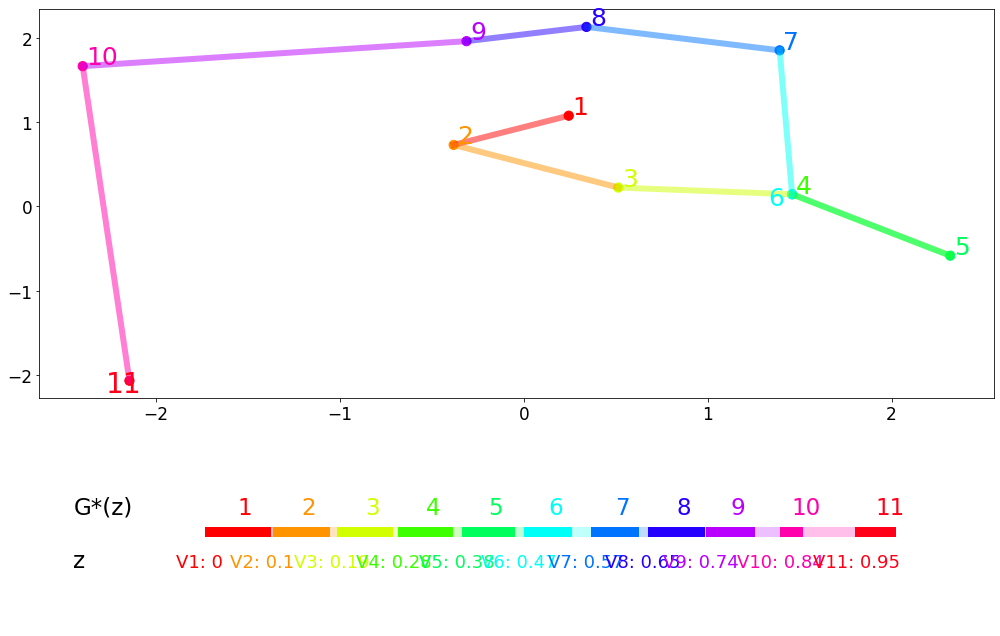

In [32]:
X = np.linspace(0,1-10**-8,1000)
Y = np.zeros((1000,2))
for i in range(1000):
    Y[i] = Psi(X[i])

XX = np.linspace(0,1-10**-8,1000)
YY = np.zeros((1000,2))
for i in range(1000):
    YY[i] = Psi(XX[i])

K = len(ThePath)*np.amax([np.linalg.norm(ThePath[i]-ThePath[i-1]) for i in range(1, len(ThePath))])
K = max(25, K)
plot_shortest_path_and_phi(ThePath, K, namefile='test')

In [38]:
def training_GANs(num_samples, num_steps, grad_gen, netG, netD):

    if opt_adam:
        optimizerD = optim.Adam(netD.parameters(), lr=opt_lrD)
        optimizerG = optim.Adam(netG.parameters(), lr=opt_lrG)
    else:
        optimizerD = optim.RMSprop(netD.parameters(), lr = opt_lrD)
        optimizerG = optim.RMSprop(netG.parameters(), lr = opt_lrG)

    losses = []
    Batchs = max(100, opt_batchSize)
    Nint = np.array([i for i in range(len(Data))])

    for epochs in range(num_steps):

        # (1) Update D network
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update

        for j in range(opt_Diters):
            netD.zero_grad()
            idx = np.random.choice(Nint, size=opt_batchSize, replace=False)
            data = Data[idx,:].reshape(1,opt_batchSize,2)
            idx = np.random.choice(Nint, size=Batchs, replace=True)
            data2 = Data[idx,:].reshape(1,Batchs,2)
            data = torch.tensor(data)
            U_data = torch.rand(Batchs).view(Batchs,1)
            U2_data = torch.rand([Batchs,2]).view(1,Batchs,2)
            interp_alpha = torch.rand(Batchs).view(1,Batchs,1)
            interp_points = interp_alpha*data2 +(1-interp_alpha)*U2_data
            interp_points.requires_grad = True

            if opt_cuda:
                data = data.cuda()
                U_data = U_data.cuda()
                interp_points = interp_points.cuda()

            errD_real_vec = netD(data)
            errD_real = errD_real_vec.mean(0)

            # train with fake
            fake = netG(U_data)
            errD_fake_vec = netD(fake.reshape(1,Batchs,2))
            errD_fake = errD_fake_vec.mean(0)
            errD = errD_real - errD_fake

            errD_interp_vec = netD(interp_points)
            errD_gradient = torch.autograd.grad(errD_interp_vec.sum(), interp_points, create_graph=True)[0]
            lip_est = (errD_gradient**2).view(Batchs,-1).sum(1)**0.5
            lip_loss = opt_penalty_weight*(clip_fn(1.0-lip_est)**2).mean(0).view(1)
            errD = errD + lip_loss
            errD.backward()
            optimizerD.step()


        # (2) Update G network
        for p in netD.parameters():
            p.requires_grad = False
        netG.zero_grad()

        U_data = torch.rand(Batchs).view(Batchs,1)
        if opt_cuda:
            U_data = U_data.cuda()

        fake = netG(U_data)
        errG = netD(fake.reshape(1,Batchs,2))
        errG = errG.mean(0).view(1)

        if grad_gen > 0:
            U_data.requires_grad = True
            errG_interp_vec = netG(U_data)
            errG_gradient = torch.autograd.grad(errG_interp_vec.sum(), U_data, create_graph=True)[0]
            lip_est = (errG_gradient**2).view(Batchs,-1).sum(1)**0.5
            lip_loss2 = 100*opt_penalty_weight*(clip_fn(grad_gen-lip_est)**2).mean(0).view(1)
            errG = errG + lip_loss2
        errG.backward()
        optimizerG.step()

        if (epochs) % 1000 == 0:
            losses.append(errD.data[0])
            XX = netG(x_to_w1.float())
            XX = XX.cpu().detach().numpy().reshape((XX.shape[0],2))
            M = cost_Matrix(XX,Data)
            W1 = ot.emd2(a,b,M)

            print('Epoch [{}/{}], num_samples {}, grad_gen {} L_D: {:.4f}, L_G: {:.4f} , L_D_real: {:.4f} ,  L_D_fake:{:.4f}, L_lip: {:.6f}, L_lip2: {:.10f}, W1: {:.4f}:  '
                          .format(epochs, num_steps, num_samples, grad_gen, errD.data.item(), errG.data.item(), errD_real.data.item(), \
                                  errD_fake.data.item(), lip_loss.data.item(),lip_loss2.data.item(),W1))
            plot_both_paths(ThePath, namefile="GANs_samples"+str(num_samples)+"_lim"+str(int(grad_gen))+"_step"+str(epochs))

In [ ]:
num_steps = 12000
num_samples = [5, 10, 20, 50]
for n in num_samples:
    Data, opt_batchSize, x_to_w1, a, b = creating_the_data(n)
    
    ThePath = get_shortest_path(Data) 
    Kmax = len(ThePath)*np.amax([np.linalg.norm(ThePath[i]-ThePath[i-1]) for i in range(1, len(ThePath))])
    print("Kmax=", Kmax)
    plot_shortest_path_and_phi(ThePath, Kmax, namefile="Gstar_"+str(n))
    
    gradients_lim_gen = [Kmax*0.1, Kmax*0.3, Kmax, Kmax*3]
    for grad_gen in gradients_lim_gen:
        netG, netD = initializing_networks()
        training_GANs(n, num_steps, grad_gen, netG, netD)

Kmax= 9.884071350097656
0.018924905019624808
Epoch [0/12000], num_samples 5, grad_gen 0.9884071350097656 L_D: -0.0273, L_G: -0.1081 , L_D_real: -0.1354 ,  L_D_fake:-0.1081, L_lip: 0.000000, L_lip2: 0.0000000000, W1: 1.3188:  
Epoch [1000/12000], num_samples 5, grad_gen 0.9884071350097656 L_D: -0.5242, L_G: -0.8948 , L_D_real: -1.4123 ,  L_D_fake:-0.8878, L_lip: 0.000264, L_lip2: 0.0000000000, W1: 0.6126:  
Epoch [2000/12000], num_samples 5, grad_gen 0.9884071350097656 L_D: -0.3981, L_G: -0.9159 , L_D_real: -1.3320 ,  L_D_fake:-0.9338, L_lip: 0.000086, L_lip2: 0.0000000000, W1: 0.4434:  
Epoch [3000/12000], num_samples 5, grad_gen 0.9884071350097656 L_D: -0.4296, L_G: -0.3517 , L_D_real: -0.8028 ,  L_D_fake:-0.3732, L_lip: 0.000072, L_lip2: 0.0000000000, W1: 0.4365:  
Epoch [4000/12000], num_samples 5, grad_gen 0.9884071350097656 L_D: -0.4171, L_G: -0.5952 , L_D_real: -1.0392 ,  L_D_fake:-0.6219, L_lip: 0.000250, L_lip2: 0.0000000000, W1: 0.4258:  
Epoch [5000/12000], num_samples 5, gra

/mnt/nfs/home/u.tanielian/few_shot_learning_gans/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch [10000/12000], num_samples 5, grad_gen 0.9884071350097656 L_D: -0.4051, L_G: -1.8634 , L_D_real: -2.2660 ,  L_D_fake:-1.8607, L_lip: 0.000223, L_lip2: 0.0000000000, W1: 0.4083:  
Epoch [11000/12000], num_samples 5, grad_gen 0.9884071350097656 L_D: -0.4091, L_G: -2.0538 , L_D_real: -2.4890 ,  L_D_fake:-2.0796, L_lip: 0.000335, L_lip2: 0.0000000000, W1: 0.4067:  
Epoch [0/12000], num_samples 5, grad_gen 2.965221405029297 L_D: -0.0277, L_G: 0.0969 , L_D_real: 0.0688 ,  L_D_fake:0.0966, L_lip: 0.000000, L_lip2: 0.0000000000, W1: 1.3718:  
Epoch [1000/12000], num_samples 5, grad_gen 2.965221405029297 L_D: -0.3995, L_G: -0.0485 , L_D_real: -0.4734 ,  L_D_fake:-0.0739, L_lip: 0.000000, L_lip2: 0.0000000000, W1: 0.7803:  
Epoch [2000/12000], num_samples 5, grad_gen 2.965221405029297 L_D: -0.3600, L_G: -0.8488 , L_D_real: -1.1580 ,  L_D_fake:-0.7980, L_lip: 0.000017, L_lip2: 0.0000000000, W1: 0.3986:  
Epoch [3000/12000], num_samples 5, grad_gen 2.965221405029297 L_D: -0.3672, L_G: 1.4592